# March Madness         2016 NCAA Prediction



-----------


## Explanatory Analysis and Model Building 

In [ ]:
%install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py
%load_ext watermark

In [3]:
%watermark -a 'Nan(Miya)Wang' -u -d -t -z -v --python

Nan(Miya)Wang 
last updated: 2016-03-16 17:10:33 Eastern Daylight Time

CPython 2.7.10
IPython 4.0.1



-------

### Explanatory Analysis:
* Feature Correlation Heatmap
* Feature Normalization Distribution 


------

### Model Building:
* Random Forest
* Linear SVM
* RBF SVM
* Neareat Neighbours
* GaussianNB
* Logistic Regression
* Bagging
* AdaBoostClassifier
* GradientBoostingClassification

> With all the models above, Random Forest, logistic regression and Gradient Boosting Classification have turned out to be the most promising models.


### Model Improvements Tricks:
* Rank into score transformation function: 1-16 seed into (0.5,0.99)
* shuffle X and Y
* cross validation
* Grid Searching/Parameter Tuning
* cross validation Feature Importance Ploting/Feature Reduction to avoid overfitting
* Feature Engineering
* PCA(doesn't work well though in our model)
* Model Ensemble (votingclassifier)


### Conclusion:
* Top Nine Features:

> 1. div_rpi_norm (0.237846)
2. div_seed_norm (0.139273)
3. div_adjoe (0.128751)
4. div_adjde (0.110354)
5. div_blockpct (0.080188)
6. div_distance (0.078126)
7. div_oppfg3pct (0.076628)
8. div_fg3pct (0.075109)
9. div_oppf3grate (0.073723)
>

* Log_loss: 0.45(beat kaggle top two in 2015)
* accuracy: 0.80

In [2]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
from matplotlib.mlab import PCA as mlabPCA
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import ShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn import preprocessing
from sklearn.decomposition import PCA, KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.structure.modules import SoftmaxLayer
from pybrain.datasets import SupervisedDataSet
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn.externals.six.moves import xrange
from sklearn.tree import DecisionTreeClassifier
from sklearn import clone
from pybrain.utilities import percentError
from pybrain.datasets import ClassificationDataSet
from sklearn.pipeline import Pipeline
from sklearn import cross_validation
from IPython.display import Image
from IPython import display
from sklearn.metrics import classification_report

## The dataset read here has done:
* Double orginal dataset for all Team 2
* adjust seed and RPI feature using mathematical functions
* Drop missing values in adjoe, adjtempo, adjde
* MaxMin method normalizing other features ranging beyond 0 and 1

## Read the Dataset

In [3]:
NCAA = pd.read_csv("ready.csv",index_col = "game_id").sort_index()
NCAA = NCAA.reindex_axis(sorted(NCAA.columns),axis = 1)

## Check Correlation Between Features

In [5]:
for i in range(len(NCAA.columns.tolist())):
    columni = NCAA.columns.tolist()[i]
    for j in range(i+1,len(NCAA.columns.tolist())-i):
        columnj = NCAA.columns.tolist()[j]
        corij = np.corrcoef(NCAA[columni],NCAA[columnj])[0,1]
        if corij>=0.6:
            print "correlation between column %s and column %s is\n%s" % (NCAA.columns.tolist()[i],NCAA.columns.tolist()[j],corij)

            
            
plt.matshow(NCAA.corr())
plt.show()
plt.close()                                                                    

correlation between column team1_adjde and column team1_oppfg2pct is
0.629759876167
correlation between column team1_ap_final and column team1_seed_norm is
0.679627362059


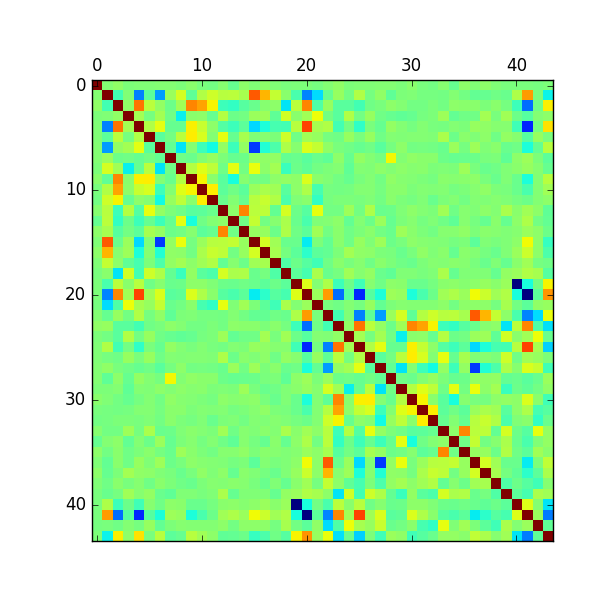

In [6]:
Image(filename='figure_1.png') 

## Plot Feature Distribution 

In [6]:
### show the distribution of features to check if they are normaly
## distributed
fig = plt.figure()
NCAA.iloc[:,1:-1].diff().hist(alpha = 0.5,layout = (6,8))
fig.show()

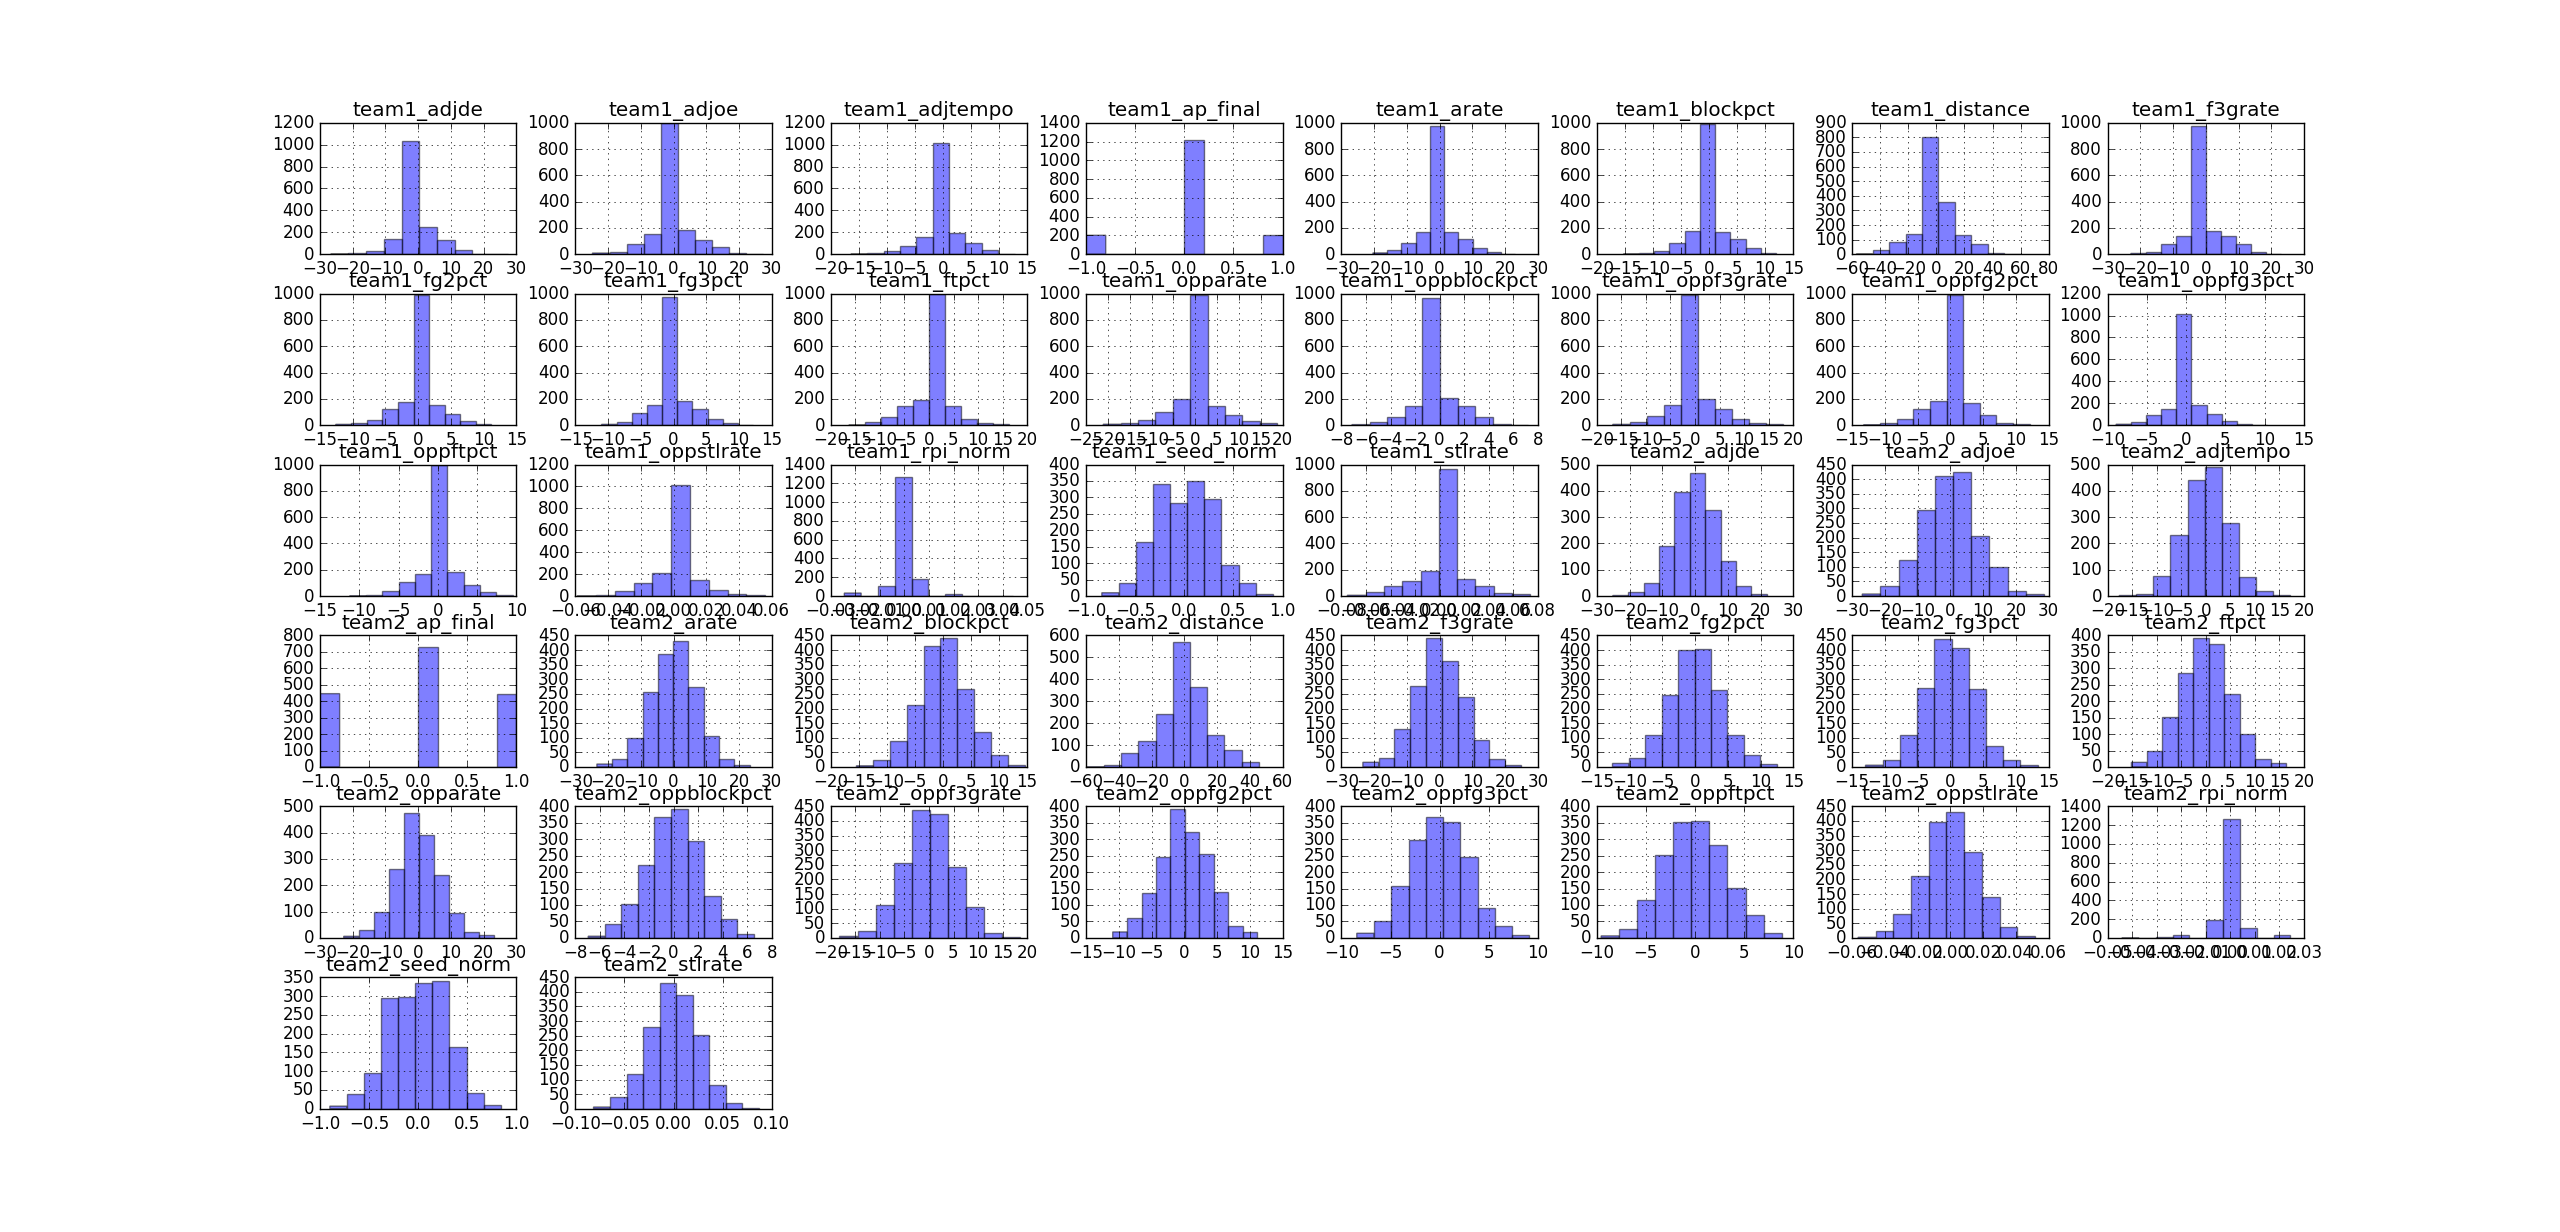

In [8]:
Image(filename='figure_2.png') 

## Feature Correlation Heatmap

In [20]:
from string import letters

import seaborn as sns

sns.set(style="whitegrid")

# Generate a large random dataset


# Compute the correlation matrix
corr = NCAA.iloc[:,1:].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
x = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=2,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation=0) 
plt.show()

In [ ]:
Image(filename='figure_3.png') 

## Normalize Features Using MinMax

In [6]:
columns_need_to_be_normalized=[1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,
                               22,23,24,26,27,28,29,30,31,32,33,34,35,36,37,38]

list= []
for i in columns_need_to_be_normalized:
    list.append(NCAA.columns.tolist()[i])
X_to_normalize = NCAA.iloc[:,columns_need_to_be_normalized]
min_max_scaler = preprocessing.MinMaxScaler()
X_normalized = min_max_scaler.fit_transform(X_to_normalize)
NCAA.iloc[:,columns_need_to_be_normalized]=X_normalized

## Features We Choose Not to Normalize

In [7]:
## to check not normalized columns
for i in NCAA.columns.tolist():
    if i not in list:
        print i

numot
team1_ap_final
team1_oppstlrate
team1_rpi_norm
team1_seed_norm
team1_stlrate
team2_ap_final
team2_oppstlrate
team2_rpi_norm
team2_seed_norm
team2_stlrate
win_or_lose


## Define Features and Dependent Variable for Model Building

In [8]:
X = NCAA.iloc[:,:-2]
Y = NCAA.iloc[:,-1]
X,Y = shuffle(X,Y,random_state = 0)

In [9]:
n_samples, n_features = X.shape
print("n_samples=%d" % n_samples)
print("n_features=%d" % n_features)

n_samples=1625
n_features=42


### Tried to Use Variance to Do Feature Seletion. 
* Failed

##doesn't work very well

selector1.fit(X = X,y = y)
selector1.get_support(True)
featuresByVariance = []
for i in list(selector1.get_support(True)):
    featuresByVariance.append(NCAA.columns[i])
featuresByVariance

### Tried to Use PercentileSelect to Do Feature Selection. 
* Make sense

for i in NCAA.columns.tolist():
    if i not in NCAA.columns[list(selector1.get_support(True))].tolist():
        print i

In [10]:
selector = SelectPercentile(percentile = 10)
X_train_fs = selector.fit_transform(X = X,y = Y)
feature_names = NCAA.columns.tolist()

##print 'All features:', feature_names
##print 'Scores of these features:', selector.scores_
allfeaturesByScore = [feature_names[i] for i in np.argsort(selector.scores_)[::-1]]
selected_columns_index = np.argsort(selector.scores_)[::-1].tolist()[:30]
allfeaturesByScore[:10]

['team2_seed_norm',
 'team1_seed_norm',
 'team1_ap_final',
 'team2_ap_final',
 'team2_adjoe',
 'team1_adjoe',
 'team2_rpi_norm',
 'team1_rpi_norm',
 'team1_adjde',
 'team2_adjde']

### RandomForest 
> ##### log_loss : 0.49

In [ ]:
%time
forest = RandomForestClassifier(n_estimators = 100)
cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=100,
                                   test_size=0.1, random_state=0)
scores_RF = cross_val_score(forest,X,Y,cv=cv,scoring = 'log_loss') ###tried cv=10: 0.788

forest.fit(X,Y)
importances_allfeatures = forest.feature_importances_
importances_allfeatures[:10]

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances_allfeatures)[::-1]
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, NCAA.columns[indices[f]], importances_allfeatures[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("All Feature importances by RandomForest")
plt.bar(range(X.shape[1]), importances_allfeatures[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
Image(filename='figure_4.png') 

In [13]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_RF.mean(), scores_RF.std() * 2))

Accuracy: -0.48 (+/- 0.09)


## Use Recursive feature Eliminaiton through Cross Validation 
> 18 is the best number

In [ ]:
## use recursive feature eliminaiton and cross validation selection (randomForest)
## of the best number of features
rfecv = RFECV(estimator=forest, step=1, cv=StratifiedKFold(Y, 15),
              scoring='log_loss')
rfecv.fit(X, Y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

## Turns out the best number features to use is ___________

In [ ]:
Image(filename='figure_5.png') 

## Use just top 18 features
> accuracy: 0.78

> logloss: 0.460


In [ ]:
%time
### use just _18____ number of features to run RandomForest

feature_18_RF = map(lambda x:x[0],sorted(enumerate(importances_allfeatures.tolist()), key = lambda k:k[1],reverse = True))[:18]
forest_18 = RandomForestClassifier(n_estimators = 300,max_features = 3,max_depth = None)
scores_18_logloss = cross_val_score(forest_18,X.iloc[:,feature_18_RF],Y,cv=cv,scoring = 'log_loss') ###tried cv=10: 0.788

# scores_18_accuracy = cross_val_score(forest_18,X.iloc[:,feature_18_RF],Y,cv=cv,scoring = 'accuracy') ###tried cv=10: 0.788

forest_18.fit(X.iloc[:,feature_18_RF],Y)

importances_18 = forest_18.feature_importances_
importances_18

std_18 = np.std([tree.feature_importances_ for tree in forest_18.estimators_],
             axis=0)
indices_18 = np.argsort(importances_18)[::-1]
for f in range(X.iloc[:,feature_18_RF].shape[1]):
    print("%d. %s (%f)" % (f + 1, X.iloc[:,feature_18_RF].columns[indices_18[f]], importances_18[indices_18[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances for RandomForest")
plt.bar(range(X.iloc[:,feature_18_RF].shape[1]), importances_18[indices_18],
       color="r", yerr=std_18[indices_18], align="center")
plt.xticks(range(X.iloc[:,feature_18_RF].shape[1]), X.iloc[:,feature_18_RF].columns[indices_18],rotation='vertical')
plt.xlim([-1, X.iloc[:,feature_18_RF].shape[1]])
plt.margins(0.2)
plt.subplots_adjust(bottom=0.3)

plt.show()

## 300,3
## log_loss: 0.45 0.46
## accuracy: 78%
## 300,4
##accuracy: 79%
## log_loss:0.46
## 300,3
## log_loss 0.46

In [ ]:
Image(filename='figure_6.png') 

In [20]:
scores_18_logloss.mean()

-0.45967797468734273

* Use _33___ number of features to run RandomForest
> the outcome is similiar to models with 24 features.

feature_33_RF = map(lambda x:x[0],sorted(enumerate(importances.tolist()), key = lambda k:k[1],reverse = True))[:33]
forest = RandomForestClassifier(n_estimators = 100)
scores_33 = cross_val_score(forest,X.iloc[:,feature_33_RF],Y,cv=15,scoring = 'log_loss') ###tried cv=10: 0.788
forest.fit(X.iloc[:,feature_33_RF],Y)
importances = forest.feature_importances_
importances

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
for f in range(X.iloc[:,feature_33_RF].shape[1]):
    print("%d. %s (%f)" % (f + 1, X.iloc[:,feature_33_RF].columns[indices[f]], importances[indices[f]]))

### Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.iloc[:,feature_33_RF].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.iloc[:,feature_33_RF].shape[1]), indices)
plt.xlim([-1, X.iloc[:,feature_33_RF].shape[1]])
plt.show()

## log_loss: 0.49/ 0.137
## accuracy: 77.8%

### Build A Pipeline

In [22]:
PipeLine = Pipeline([('FOREST with 18 features',forest_18)])
scores_PipeLine = cross_val_score(PipeLine,X.iloc[:,feature_18_RF],Y,cv=cv,scoring = 'log_loss')
scores_PipeLine.mean()

-0.45850130549440371

### Linear SVM
> accuracy: 71%

> log_loss:0.544

In [10]:
svc = SVC(kernel="linear",probability=True)
# The "accuracy" scoring is proportional to the number of correct
# classifications
scores_svc = cross_val_score(svc,X,Y,cv=15,scoring = 'log_loss')
svc.fit(X,Y)
svc.predict_proba(X)
scores_svc.mean()

-0.54395908692169526

### Linear SVM Feature Importance

In [11]:
svc_featurelist = map(lambda x:x[0],sorted(enumerate(svc.coef_.tolist()[0]),key=lambda x:x[1]))
svc_feature_importance = X.iloc[0,svc_featurelist].index.tolist()
svc_feature_importance[:10]

['team2_adjoe',
 'team1_adjde',
 'team2_seed_norm',
 'team1_arate',
 'team2_rpi_norm',
 'team1_distance',
 'team2_oppblockpct',
 'team2_blockpct',
 'team1_f3grate',
 'team2_oppfg2pct']

In [12]:
## use recursive feature eliminaiton and cross validation selection (support vector machine)
## of the best number of features
svcecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(Y, 15),
              scoring='log_loss')
svcecv.fit(X, Y)

print("Optimal number of features : %d" % svcecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(svcecv.grid_scores_) + 1), svcecv.grid_scores_)
plt.show()

Optimal number of features : 10


In [13]:
## Train svc model with just 10 features
svc = SVC(kernel="linear",probability=True)
# The "accuracy" scoring is proportional to the number of correct
# classifications
scores_svc_10 = cross_val_score(svc,X.iloc[:,svc_featurelist[:10]],Y,cv=15,scoring = 'log_loss')
svc.fit(X.iloc[:,svc_featurelist[:10]],Y)
svc.predict_proba(X.iloc[:,svc_featurelist[:10]])
scores_svc_10.mean()


## log_loss: 0.5519

-0.55203142497101554

### 'RBF' SVM
> log_loss: 0.57

In [15]:
svc_2 = SVC(kernel='rbf',C = 100,gamma = 0.05,probability=True)
scores_svc_2 = cross_val_score(svc_2,X,Y,cv=15,scoring = 'log_loss')

### Neareat Neighbours
> log_loss: 0.56

In [ ]:
## nearest neighbours
neigh = KNeighborsClassifier(n_neighbors=50)
neigh.fit(X, Y)
scores = cross_val_score(neigh,X,Y,cv=15,scoring = 'log_loss')
scores.mean()

### Trying PCA
> log_loss: 0.56

> accuracy: 0.69

pca is not good

In [43]:
pca = PCA(n_components=15)
pca.fit(X)
PCA(copy=True, n_components = 15,whiten=False)
print(pca.explained_variance_ratio_) 

[ 0.28313017  0.15454392  0.06786729  0.04370454  0.04293297  0.03150626
  0.02881426  0.02709225  0.02379844  0.02235255  0.02027542  0.01993137
  0.01861389  0.01717468  0.01700075]


In [44]:
X_pca = pca.fit_transform(X.iloc[:,feature_18_RF])

In [45]:
forest_pca = RandomForestClassifier(n_estimators = 300,max_features = 3,max_depth = None)
scores_pca = cross_val_score(forest_pca,X_pca,Y,cv=15,scoring = 'log_loss') ###tried cv=10: 0.788

forest_pca.fit(X_pca,Y)
importances_pca = forest_pca.feature_importances_
importances_pca
scores_pca.mean()

-0.55717897876352318

### GaussianNB
> accuracy: 0.74

> log_loss: 0.95

In [8]:
gnb = GaussianNB()
gnb.fit(X_new,Y_new)
scores_gnb = cross_val_score(gnb,X_new,Y_new,cv=15,scoring = 'accuracy')
scores_gnb.mean()

0.73598935326764081

### Logistic Regression
>  log_loss: 0.54

> accuracy:0.72

In [51]:
lr = LogisticRegression()
lr.fit(X, Y)
scores_lr = cross_val_score(lr,X,Y,cv=15,scoring = "log_loss")
scores_lr.mean()

-0.54178198256530452

### Grid Search to Tune Parameters
> when C is  3250 the scores are the best:

> 0.528      73.8%

In [20]:
from sklearn.grid_search import GridSearchCV
param_grid = {'C':range(3245,3255,1) }
lr_grid = GridSearchCV(LogisticRegression(penalty='l2'), param_grid,cv =cv,scoring ='accuracy')
lr_grid.fit(X,Y).best_score_

0.73809815950920243

## Bagging 
>LOG_LOSS: 0.578

>accuracy:0.70

In [16]:
##In ensemble algorithms, bagging methods form 
##a class of algorithms which build several instances of a black-box estimator on random subsets of the original training set and then aggregate their individual predictions to form a final prediction. These methods are used as a way to reduce the variance of a base estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it. In many cases, bagging methods constitute a very simple way to improve with respect to a single model, without making it necessary to adapt the underlying base algorithm. As they provide a way to reduce overfitting, bagging methods work best with strong and complex models (e.g., fully developed decision trees), in contrast with boosting methods which usually work best with weak models (e.g., shallow decision trees)
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(),
                            max_samples=0.5, max_features=0.5)
scores_bagging = cross_val_score(bagging, X, Y,cv = 15,scoring = 
                                'accuracy')
bagging.fit(X,Y)
scores_bagging.mean()

0.67999619024083857

## ExtraTreesClassifier

In [17]:
dt= DecisionTreeClassifier(max_depth=None, min_samples_split=1,
                           random_state=0)
scores_dt = cross_val_score(dt, X, Y,cv = 15,scoring = 'log_loss')


ET = ExtraTreesClassifier(n_estimators=10, max_depth=None,
                          min_samples_split=1, random_state=0)
scores_ET = cross_val_score(ET, X, Y,cv = 15,scoring='accuracy')


In [18]:
scores_dt.mean()

-10.864733500386366

### AdaBoostClassifier
> 0.68

In [19]:
Ada = AdaBoostClassifier(n_estimators=100)
scores_Ada = cross_val_score(Ada,X,Y,scoring = 'log_loss',cv = 15)
scores_Ada.mean()  
Ada.fit(X,Y)
importances = Ada.feature_importances_
importances
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))


1. team2_adjoe (0.060000)
2. team1_seed_norm (0.050000)
3. team1_distance (0.050000)
4. team2_rpi_norm (0.050000)
5. team1_rpi_norm (0.050000)
6. team1_adjoe (0.050000)
7. team1_adjtempo (0.040000)
8. team1_f3grate (0.040000)
9. team1_ftpct (0.040000)
10. team2_distance (0.040000)
11. team1_opparate (0.030000)
12. team2_oppstlrate (0.030000)
13. team1_stlrate (0.030000)
14. team2_adjde (0.030000)
15. team1_oppblockpct (0.030000)
16. team2_blockpct (0.030000)
17. team2_arate (0.030000)
18. team2_ftpct (0.030000)
19. team2_opparate (0.030000)
20. team1_arate (0.020000)
21. team1_adjde (0.020000)
22. team1_oppftpct (0.020000)
23. team1_fg2pct (0.020000)
24. team2_seed_norm (0.020000)
25. team2_adjtempo (0.020000)
26. team2_f3grate (0.020000)
27. team2_oppblockpct (0.020000)
28. team2_oppf3grate (0.020000)
29. team2_fg3pct (0.010000)
30. team2_oppfg2pct (0.010000)
31. team1_oppfg2pct (0.010000)
32. team1_oppf3grate (0.010000)
33. team2_oppftpct (0.010000)
34. team1_fg3pct (0.010000)
35. te

In [ ]:
Ada.feature_importances_

### GradientBoostingClassifier


In [11]:
GB = GradientBoostingClassifier(n_estimators=100, learning_rate=0.02,
                                max_depth=3, random_state=0)
scores_GB = cross_val_score(GB,X_new,Y_new,scoring = 'log_loss',cv = 15) 

In [12]:
scores_GB.mean()

-0.48389712677575969

## Trying Pybrain to Run Neural Network
> accuracy is just 50%
------
* sad

In [151]:
ds = ClassificationDataSet(42,1)

tf = open('normalized_NN.csv','r')

for line in tf.readlines():
    data = [x for x in line.strip().split(',') if x != '']
    indata =  tuple(data[:42])
    outdata = tuple(data[43])
    ds.addSample(indata,outdata)
tstdata_temp, trndata_temp = ds.splitWithProportion(0.25)


In [189]:
len(trndata)

1219

In [154]:
tstdata = ClassificationDataSet(42, 1)
for n in xrange(0, tstdata_temp.getLength()):
    tstdata.addSample(tuple(tstdata_temp.getSample(n)[0]),tuple(tstdata_temp.getSample(n)[1]))

trndata = ClassificationDataSet(42, 1)
for n in xrange(0, trndata_temp.getLength()):
    trndata.addSample(tuple(trndata_temp.getSample(n)[0]),tuple(trndata_temp.getSample(n)[1]))


trndata._convertToOneOfMany( )
tstdata._convertToOneOfMany( )

In [231]:
n = buildNetwork(trndata.indim,44,100,100, trndata.outdim, outclass=SoftmaxLayer )
t = BackpropTrainer(n,dataset = trndata,learningrate=0.0002,verbose=True)

In [ ]:
tstdata['class']

In [232]:
accuracy_score(t.testOnClassData(dataset = tstdata), tstdata['class'])

0.54187192118226601

In [168]:
trnresult = percentError(t.testOnClassData(),
                              trndata['class'] )
tstresult = percentError(t.testOnClassData(
           dataset=tstdata ), tstdata['class'] )

In [169]:
trnresult

51.43560295324036

# Feature Engineering to Reduce the number of features

In [6]:
columns_team1 =  ['team1_adjde',
 'team1_adjoe',
 'team1_adjtempo',
 'team1_arate',
 'team1_blockpct',
 'team1_distance',
 'team1_f3grate',
 'team1_fg2pct',
 'team1_fg3pct',
 'team1_ftpct',
 'team1_opparate',
 'team1_oppblockpct',
 'team1_oppf3grate',
 'team1_oppfg2pct',
 'team1_oppfg3pct',
 'team1_oppftpct',
 'team1_oppstlrate',
 'team1_rpi_norm',
 'team1_seed_norm',
 'team1_stlrate']
columns_team2 = ['team2_adjde',
 'team2_adjoe',
 'team2_adjtempo',
 'team2_arate',
 'team2_blockpct',
 'team2_distance',
 'team2_f3grate',
 'team2_fg2pct',
 'team2_fg3pct',
 'team2_ftpct',
 'team2_opparate',
 'team2_oppblockpct',
 'team2_oppf3grate',
 'team2_oppfg2pct',
 'team2_oppfg3pct',
 'team2_oppftpct',
 'team2_oppstlrate',
 'team2_rpi_norm',
 'team2_seed_norm',
 'team2_stlrate']
columns_game = ['div_adjde',
 'div_adjoe',
 'div_adjtempo',
 'div_arate',
 'div_blockpct',
 'div_distance',
 'div_f3grate',
 'div_fg2pct',
 'div_fg3pct',
 'div_ftpct',
 'div_opparate',
 'div_oppblockpct',
 'div_oppf3grate',
 'div_oppfg2pct',
 'div_oppfg3pct',
 'div_oppftpct',
 'div_oppstlrate',
 'div_rpi_norm',
 'div_seed_norm',
 'div_stlrate']

for a in zip(columns_team1,columns_team2,columns_game):
    NCAA[a[2]] = NCAA[a[0]]-NCAA[a[1]]
    
list_duplicates = ['team1_adjde',
 'team1_adjoe',
 'team1_adjtempo',
 'team1_arate',
 'team1_blockpct',
 'team1_distance',
 'team1_f3grate',
 'team1_fg2pct',
 'team1_fg3pct',
 'team1_ftpct',
 'team1_opparate',
 'team1_oppblockpct',
 'team1_oppf3grate',
 'team1_oppfg2pct',
 'team1_oppfg3pct',
 'team1_oppftpct',
 'team1_oppstlrate',
 'team1_rpi_norm',
 'team1_seed_norm',
 'team1_stlrate',
  'team2_adjde',
 'team2_adjoe',
 'team2_adjtempo',
 'team2_arate',
 'team2_blockpct',
 'team2_distance',
 'team2_f3grate',
 'team2_fg2pct',
 'team2_fg3pct',
 'team2_ftpct',
 'team2_opparate',
 'team2_oppblockpct',
 'team2_oppf3grate',
 'team2_oppfg2pct',
 'team2_oppfg3pct',
 'team2_oppftpct',
 'team2_oppstlrate',
 'team2_rpi_norm',
 'team2_seed_norm',
 'team2_stlrate']

 

In [7]:
for i in range(len(list_duplicates)):
    NCAA = NCAA.drop(list_duplicates[i],1)
NCAA.columns

Index([u'numot', u'team1_ap_final', u'team2_ap_final', u'win_or_lose',
       u'div_adjde', u'div_adjoe', u'div_adjtempo', u'div_arate',
       u'div_blockpct', u'div_distance', u'div_f3grate', u'div_fg2pct',
       u'div_fg3pct', u'div_ftpct', u'div_opparate', u'div_oppblockpct',
       u'div_oppf3grate', u'div_oppfg2pct', u'div_oppfg3pct', u'div_oppftpct',
       u'div_oppstlrate', u'div_rpi_norm', u'div_seed_norm', u'div_stlrate'],
      dtype='object')

#### Read the new dataframe into csv file

In [3]:
NCAA_new = pd.read_csv("NCAA_new.csv",index_col = "game_id")
X_new = NCAA_new.iloc[:,:-2]
Y_new = NCAA_new.iloc[:,-1]
X_new,Y_new = shuffle(X_new,Y_new,random_state = 0)

### RandomForest With All features
> log loss: 0.466

In [ ]:
%time
forest_new = RandomForestClassifier(n_estimators = 100)
cv_new = cross_validation.ShuffleSplit(X_new.shape[0], n_iter=100,
                                   test_size=0.1, random_state=0)
scores_RF_new = cross_val_score(forest_new,X_new,Y_new,cv=cv_new,scoring = 'log_loss') ###tried cv=10: 0.788
                                 
forest_new.fit(X_new,Y_new)
importances_allfeatures_new = forest_new.feature_importances_
importances_allfeatures_new[:10]
                                       
std_new = np.std([tree.feature_importances_ for tree in forest_new.estimators_],
             axis=0)
indices_new = np.argsort(importances_allfeatures_new)[::-1]
for f in range(X_new.shape[1]):
    print("%d. %s (%f)" % (f + 1, NCAA_new.columns[indices_new[f]], importances_allfeatures_new[indices_new[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("All Feature importances")
plt.bar(range(X_new.shape[1]), importances_allfeatures_new[indices_new],
       color="r", yerr=std_new[indices_new], align="center")
plt.xticks(range(X_new.shape[1]), indices_new)
plt.xlim([-1, X_new.shape[1]])
plt.show()    

In [5]:
scores_RF_new.mean()

-0.46814975180086355

### Feature Reduction to 9

In [5]:
## use recursive feature eliminaiton and cross validation selection (randomForest)
## of the best number of features
rfecv = RFECV(estimator=forest_new, step=1, cv=StratifiedKFold(Y_new, 15),
              scoring='log_loss')
rfecv.fit(X_new, Y_new)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_,color = 'red',linewidth = 3.0)
plt.show()

## Turns out the best number features to use is ___________

Optimal number of features : 8


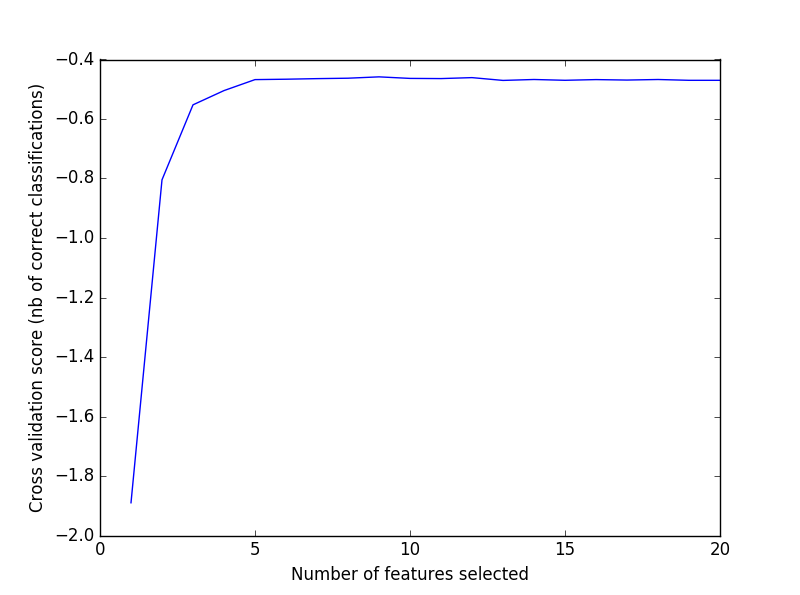

In [7]:
Image('figure_11.png')

### RandomForest with Just 9 Features
> log loss: 0.456

> accuracy: 0.804

In [ ]:
feature_9_RF_new = map(lambda x:x[0],sorted(enumerate(importances_allfeatures_new.tolist()), key = lambda k:k[1],reverse = True))[:9]
X_new_9_feature = X_new.iloc[:,feature_9_RF_new]
X_new_9_feature.head()
train = X_new_9_feature.reindex_axis(sorted(X_new_9_feature.columns), axis=1)
train

In [131]:
X_new.iloc[:,feature_9_RF_new].shape[0]

1625

In [7]:
feature_9_RF_new = map(lambda x:x[0],sorted(enumerate(importances_allfeatures_new.tolist()), key = lambda k:k[1],reverse = True))[:9]
forest_9_new = RandomForestClassifier(n_estimators = 300,max_features = 2,max_depth = None)
cv_new = cross_validation.ShuffleSplit(X_new.iloc[:,feature_9_RF_new].shape[0], n_iter=100,
                                   test_size=0.1, random_state=0)
scores_RF_9_new = cross_val_score(forest_9_new,X_new.iloc[:,feature_9_RF_new],Y_new,cv=cv_new,scoring = 'log_loss') ###tried cv=10: 0.788
                                 
forest_9_new.fit(X_new.iloc[:,feature_9_RF_new],Y_new)
importances_9features_new = forest_9_new.feature_importances_
importances_9features_new
                                       
std_9_new = np.std([tree.feature_importances_ for tree in forest_9_new.estimators_],
             axis=0)
indices_9_new = np.argsort(importances_9features_new)[::-1]
for f in range(X_new.iloc[:,feature_9_RF_new].shape[1]):
    print("%d. %s (%f)" % (f + 1, X_new.iloc[:,feature_9_RF_new].columns[indices_9_new[f]], importances_9features_new[indices_9_new[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("9 Feature importances for RandomForest")
plt.bar(range(X_new.iloc[:,feature_9_RF_new].shape[1]), importances_9features_new[indices_9_new],
       color="r", yerr=std_new[indices_9_new], align="center")
plt.xticks(range(X_new.iloc[:,feature_9_RF_new].shape[1]), X_new.iloc[:,feature_9_RF_new].columns[indices_9_new],rotation = 'vertical',
          fontsize = 15)
plt.xlim([-1, X_new.iloc[:,feature_9_RF_new].shape[1]])
plt.margins(0.2)
plt.subplots_adjust(bottom=0.3)
plt.show()    

1. div_rpi_norm (0.233777)
2. div_seed_norm (0.137366)
3. div_adjoe (0.135548)
4. div_adjde (0.107966)
5. div_distance (0.079196)
6. div_blockpct (0.079011)
7. div_oppfg2pct (0.077985)
8. div_oppfg3pct (0.075434)
9. div_oppf3grate (0.073716)


In [13]:
scores_RF_9_new = cross_val_score(forest_9_new,X_new.iloc[:,feature_9_RF_new],Y_new,cv=10,scoring = 'log_loss')###tried cv=10: 0.788

In [29]:
plt.boxplot(scores_RF_9_new.tolist())
plt.show()


In [33]:
pd.DataFrame(scores_RF_9_new.tolist()).to_csv('cv.csv')

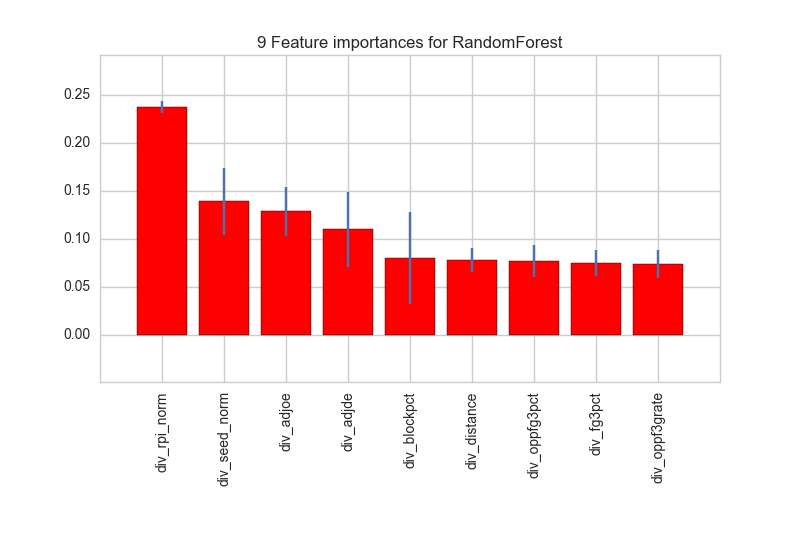

In [30]:
Image("figure_7.png")

In [7]:
scores_RF_9_new.mean()

-0.45057172946654311

In [10]:
output_RF = map(lambda x:x[1],forest_9_new.predict_proba(X_new))

In [23]:
classification_report(Y_new_sorted.iloc[1493:],forest_9_new.predict(X_new_sorted.iloc[1493:,:]))

'             precision    recall  f1-score   support\n\n          0       0.83      0.80      0.82        66\n          1       0.81      0.83      0.82        66\n\navg / total       0.82      0.82      0.82       132\n'

In [96]:
scores_RF_9_new_accuracy.mean()

0.80417177914110438

In [8]:
from sklearn.grid_search import GridSearchCV
param_grid = {'C':range(3245,3255,1) }
lr_grid = GridSearchCV(LogisticRegression(penalty='l2'), param_grid,cv=cv_new,scoring ='log_loss')
lr_grid.fit(X_new.iloc[:,feature_9_RF_new],Y_new).best_score_

-0.49389611596709537

In [50]:
from sklearn.ensemble import VotingClassifier
models = [('rf',forest_9_new),('lr',lr_grid)]
ensemble = VotingClassifier(estimators = models,voting = 'soft')

In [51]:
ensemble.fit(X_new.iloc[:,feature_9_RF_new],Y_new)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_s...51, 3252, 3253, 3254]},
       pre_dispatch='2*n_jobs', refit=True, scoring='log_loss', verbose=0))],
         voting='soft', weights=None)

In [55]:
ensemble.predict_proba(X_new.iloc[:,feature_9_RF_new])

array([[ 0.92977581,  0.07022419],
       [ 0.31374262,  0.68625738],
       [ 0.29751383,  0.70248617],
       ..., 
       [ 0.27593146,  0.72406854],
       [ 0.63142397,  0.36857603],
       [ 0.30030526,  0.69969474]])

# Add ap_preseason and ap_final

-------------

* log_loss: 0.451 (mean)
* accuracy: 0.8
* std: 0.028


> log loss mean( 0.45) has little change compared to '9 -features' model without ap 

> log loss std, however, shows great variance: log loss fluctuates in the larger range of 0.346 to 0.58

> Conclusioin: AP can be either very instructional or misleading

# Use the function 0.5+0.02*(25-AP) to transform the AP rank into score

In [8]:
'''team1 = data.team1_ap_preseason.tolist()
team2 = data.team2_ap_preseason.tolist()
for i in range(len(team1)):
    if team1[i]==0:
        team1[i]=0
    else:
        team1[i]=0.5 + 0.02 * (25-(team1[i]))
        
for i in range(len(team2)):
    if team2[i]==0:
        team2[i]=0
    else:
        team2[i]=0.5 + 0.02 * (25-(team2[i]))
        
        
        
data.team1_ap_preseason = team1
data.team2_ap_preseason = team2


data.to_csv('NCAA_new_2.csv')'''

"team1 = data.team1_ap_preseason.tolist()\nteam2 = data.team2_ap_preseason.tolist()\nfor i in range(len(team1)):\n    if team1[i]==0:\n        team1[i]=0\n    else:\n        team1[i]=0.5 + 0.02 * (25-(team1[i]))\n        \nfor i in range(len(team2)):\n    if team2[i]==0:\n        team2[i]=0\n    else:\n        team2[i]=0.5 + 0.02 * (25-(team2[i]))\n        \n        \n        \ndata.team1_ap_preseason = team1\ndata.team2_ap_preseason = team2\n\n\ndata.to_csv('NCAA_new_2.csv')"

In [2]:
NCAA_add_ap = pd.read_csv("NCAA_new_2.csv",index_col = 'game_id')

In [ ]:
original = pd.read_csv('NCAAall.csv',index_col = 'game_id')
ap_final = original[['team1_ap_final','team2_ap_final']]
dict = {np.nan:0}
ap_final = ap_final.replace(dict)
team1 = ap_final.team1_ap_final.tolist()
team2 = ap_final.team2_ap_final.tolist()
for i in range(len(team1)):
    if team1[i]==0:
        team1[i]=0
    else:
        team1[i]=0.5 + 0.02 * (25-(team1[i]))
        
for i in range(len(team2)):
    if team2[i]==0:
        team2[i]=0
    else:
        team2[i]=0.5 + 0.02 * (25-(team2[i]))
        
        
        
ap_final['team1_ap_finalx'] = team1
ap_final['team2_ap_finalx'] = team2
ap_final

In [6]:
NCAA_add_ap = pd.concat([NCAA_add_ap,ap_final],join = 'inner',axis = 1)

In [7]:
NCAA_add_ap = NCAA_add_ap.drop('numot',1)
NCAA_add_ap = NCAA_add_ap.drop('team1_ap_final',1)
NCAA_add_ap = NCAA_add_ap.drop('team2_ap_final',1)

In [ ]:
NCAA_add_ap['div_ap_final'] = NCAA_add_ap.team1_ap_finalx - NCAA_add_ap.team2_ap_finalx
NCAA_add_ap = NCAA_add_ap.drop('team2_ap_finalx',1)
NCAA_add_ap = NCAA_add_ap.drop('team1_ap_finalx',1)
NCAA_add_ap

In [9]:
NCAA_add_ap = NCAA_add_ap.drop('div_ap_preseason',1)

In [10]:
NCAA_add_ap.to_csv('NCAA_new_3.csv')

In [ ]:
NCAA_add_ap = NCAA_add_ap.reindex_axis(sorted(NCAA_add_ap.columns), axis=1)
NCAA_add_ap

In [12]:
X_new = NCAA_add_ap.iloc[:,:-1]
Y_new = NCAA_add_ap.iloc[:,-1]
X_new,Y_new = shuffle(X_new,Y_new,random_state = 0)

In [14]:
%time
forest_ap = RandomForestClassifier(n_estimators = 100)
cv_new = cross_validation.ShuffleSplit(X_new.shape[0], n_iter=100,
                                   test_size=0.1, random_state=0)
scores_RF_ap = cross_val_score(forest_ap,X_new,Y_new,cv=cv_new,scoring = 'log_loss') ###tried cv=10: 0.788
                                 
forest_ap.fit(X_new,Y_new)
importances_allfeatures_new = forest_ap.feature_importances_
importances_allfeatures_new[:10]
                                       
std_new = np.std([tree.feature_importances_ for tree in forest_ap.estimators_],
             axis=0)
indices_new = np.argsort(importances_allfeatures_new)[::-1]
for f in range(X_new.shape[1]):
    print("%d. %s (%f)" % (f + 1, NCAA_add_ap.columns[indices_new[f]], importances_allfeatures_new[indices_new[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("All Feature importances")
plt.bar(range(X_new.shape[1]), importances_allfeatures_new[indices_new],
       color="r", yerr=std_new[indices_new], align="center")
plt.xticks(range(X_new.shape[1]), indices_new)
plt.xlim([-1, X_new.shape[1]])
plt.show()    

Wall time: 0 ns
1. div_rpi_norm (0.186753)
2. div_ap_final (0.097525)
3. div_seed_norm (0.081519)
4. div_adjoe (0.069410)
5. div_adjde (0.057395)
6. div_blockpct (0.038272)
7. div_distance (0.037672)
8. div_fg3pct (0.035940)
9. div_oppfg3pct (0.034043)
10. div_oppfg2pct (0.033587)
11. div_fg2pct (0.033235)
12. div_stlrate (0.032943)
13. div_oppf3grate (0.032260)
14. div_ftpct (0.030212)
15. div_opparate (0.029803)
16. div_oppblockpct (0.029651)
17. div_adjtempo (0.029531)
18. div_oppstlrate (0.028803)
19. div_arate (0.028554)
20. div_oppftpct (0.027542)
21. div_f3grate (0.025351)


In [15]:
scores_RF_ap.mean()

-0.46846846787634133

In [16]:
## use recursive feature eliminaiton and cross validation selection (randomForest)
## of the best number of features
rfecv = RFECV(estimator=forest_ap, step=1, cv=StratifiedKFold(Y_new, 15),
              scoring='log_loss')
rfecv.fit(X_new, Y_new)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

## Turns out the best number features to use is ___________

Optimal number of features : 11


## 10 features would yield best score

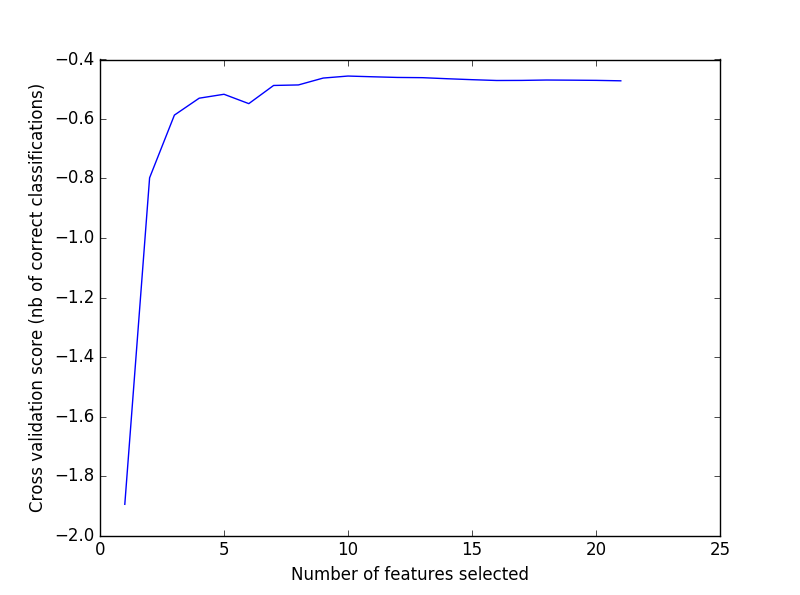

In [94]:
Image("figure_8.png")

In [17]:
# 6 means 10 here.....
feature_6_RF_ap = map(lambda x:x[0],sorted(enumerate(importances_allfeatures_new.tolist()), key = lambda k:k[1],reverse = True))[:10]
forest_6_ap = RandomForestClassifier(n_estimators = 300,max_features = 2,max_depth = None)
cv_new = cross_validation.ShuffleSplit(X_new.iloc[:,feature_6_RF_ap].shape[0], n_iter=100,
                                   test_size=0.1, random_state=0)
scores_RF_6_new = cross_val_score(forest_6_ap,X_new.iloc[:,feature_6_RF_ap],Y_new,cv=cv_new,scoring = 'log_loss') ###tried cv=10: 0.788
                                 
forest_6_ap.fit(X_new.iloc[:,feature_6_RF_ap],Y_new)
importances_6features_new = forest_6_ap.feature_importances_
importances_6features_new
                                       
std_6_new = np.std([tree.feature_importances_ for tree in forest_6_ap.estimators_],
             axis=0)
indices_6_new = np.argsort(importances_6features_new)[::-1]
for f in range(X_new.iloc[:,feature_6_RF_ap].shape[1]):
    print("%d. %s (%f)" % (f + 1, X_new.iloc[:,feature_6_RF_ap].columns[indices_6_new[f]], importances_6features_new[indices_6_new[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("10 Feature importances for RandomForest")
plt.bar(range(X_new.iloc[:,feature_6_RF_ap].shape[1]), importances_6features_new[indices_6_new],
       color="r", yerr=std_new[indices_6_new], align="center")
plt.xticks(range(X_new.iloc[:,feature_6_RF_ap].shape[1]), X_new.iloc[:,feature_6_RF_ap].columns[indices_6_new],rotation = 'vertical',
          fontsize = 15)
plt.xlim([-1, X_new.iloc[:,feature_6_RF_ap].shape[1]])
plt.margins(0.2)
plt.subplots_adjust(bottom=0.3)
plt.show()    

1. div_rpi_norm (0.225276)
2. div_adjoe (0.113486)
3. div_ap_final (0.110799)
4. div_seed_norm (0.109041)
5. div_adjde (0.092051)
6. div_distance (0.072715)
7. div_oppfg2pct (0.070721)
8. div_blockpct (0.069947)
9. div_fg3pct (0.069927)
10. div_oppfg3pct (0.066037)


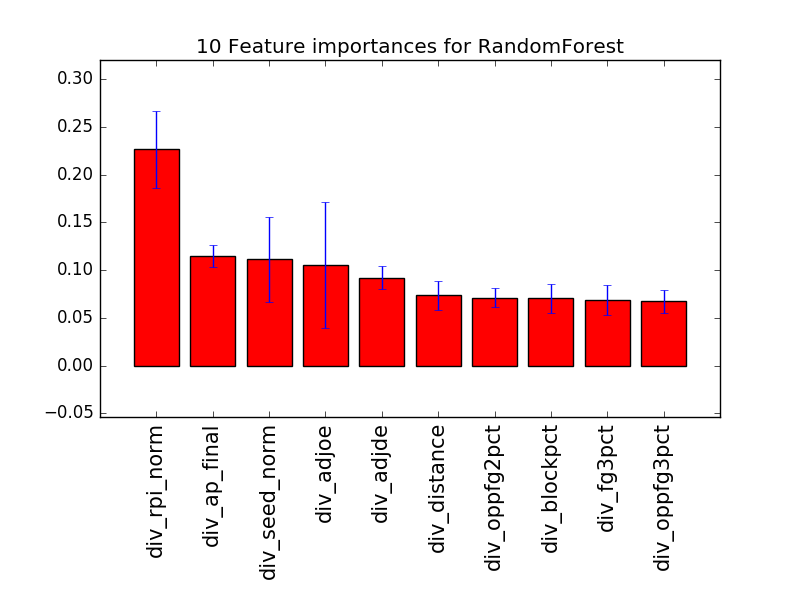

In [97]:
Image("figure_9.png")

In [18]:
scores_RF_6_new.mean()

-0.45400394040862102

In [19]:
scores_RF_6_new.max()

-0.38550496527075312

In [20]:
scores_RF_6_new.min()

-0.5401707260136106

In [21]:
scores_RF_6_new.std()

0.034596334925269485

In [102]:
accuracy_RF_6_new = cross_val_score(forest_6_ap,X_new.iloc[:,feature_6_RF_ap],Y_new,cv=cv_new,scoring = 'accuracy')

In [103]:
accuracy_RF_6_new.std()

0.029054828694998189

In [104]:
accuracy_RF_6_new.mean()

0.80042944785276082